# Network analysis of Artists

The main purpose of this section has been developing a network analysis of the colaborations between the top 100 artists for each 7 genres defined. With it, each user can be able to abstract useful information from the colaborations between the different top artists per genre, see which genres tend to have more colaborations between artists, see if the different artists tend to do collaborations with artists within the same genre or a different ones, between others. At the end, we would also like to realize if we can try to to create a small recommendation system from the tools learnt during the course.

To be able to achieve all previous statement, first, some python libraries' instalations are been needed and we have also downloaded the previous obtained data from spotify from our public repository.



In [531]:
#Libraries installations needed
!pip install spotipy
!pip install fa2
!pip install python-louvain

In [0]:
#rm -rf SGI_Sportify_Project/

In [533]:
#Clone our public repository to obtain all downloaded data
!git clone https://github.com/balbinavr/SGI_Sportify_Project.git

fatal: destination path 'SGI_Sportify_Project' already exists and is not an empty directory.


In [0]:
#Import all needed libraries
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import matplotlib.patches as mpatches
from community import community_louvain
from random import choice
import warnings
warnings.filterwarnings("ignore")

Then, we have used the *artists.csv* , *artists_colabs.csv* and *artists_colabs_singles.csv* files to create a network of colaborations from which we will work from now on.

To better understand the data obtained, we first decided to create a *directed graph* with the following characteristics:

* Node : Artist inside the top 100 of each genre
    * Name attribute for each node
* Edge : Colaboration between artists
    * In node: Artist in which the song was obtained
    * Out node: Artist colaborator to that song
    * Edge weight : Number of times that they have colaborated
    
Networkx python library has been used to generate our desired graph. In order to create the graph correctly, we have needed to keep just the colaborations between the artists that belong to the top 100 of the 7 genres chosen.

Using the iteration, a dictionary with all genres for each artist has been created. Having this information kept will be useful on further parts of the analysis , as one artist can belong to several different genres.

In [0]:
#Define genres that will be used
genres = ['pop','rock','hip-hop','blues','indie','country','soul']

#Load the list of artists and their related information
artistsList = pd.read_csv('./SGI_Sportify_Project/artists.csv', encoding='utf-8')
#Load the list of colaborations between artists
colaborationsListAlbums = pd.read_csv('./SGI_Sportify_Project/artists_colab.csv', encoding='utf-8',engine='python')
colaborationsListSingles = pd.read_csv('./SGI_Sportify_Project/artists_colab_singles.csv', encoding='utf-8',engine='python')
frames = [colaborationsListAlbums,colaborationsListSingles]
colaborationsList = pd.concat(frames)

In [0]:
#Create a dictionary with all the artists for each genre (Key:Genre, Values:List of artists per genre)
#artistsPerGenre_dict = dict()
#for genre in genres:
  #artistsGenre = artistsList[artistsList['Genre'] == genre]
  #artistsPerGenre_dict[genre] = artistsGenre.Artist_id.values

In [0]:
#Create empty directional graph
G = nx.DiGraph()

In [0]:
#Create a dictionary with all colaborations for each artist (Key:Artist, Values:List of artists and number of colaborations done)
artistsColabDict = dict()
#Create a dictionary with all genres for each artist (Key:Artist, Values:List of genres per artist)
genre_dict = dict()
names_dict = dict()

#Iterate for the list of artists
for artist in artistsList.iterrows():
    
    #Fill genre_dict
    if artist[1]['Artist_id'] in genre_dict:
      genresArtist = genre_dict[artist[1]['Artist_id']]
      genresArtist.append(artist[1]['Genre'])
      genre_dict[artist[1]['Artist_id']] = genresArtist
    else:
      genre_dict[artist[1]['Artist_id']] = [artist[1]['Genre']]
      
    #Create a node and the attributes for each artist
    G.add_node(artist[1]['Artist_id'])
    nx.set_node_attributes(G, {artist[1]['Artist_id']: {"Genre": artist[1]['Genre'], "Name": artist[1]['Artist']}})
    
    names_dict[artist[1]['Artist_id']] = artist[1]['Artist']
  
    #Keep the information about the colaboration created inside the artistsColabDict
    #If the information for that artist is already on the dict we skip it
    if (artistsColabDict.get(artist[1]['Artist_id']) is None):
      #Create the collaborationsList
      #Find all the artists that have colaborated with current artist
      #And count the number of collaborations done with each artist
      artistsColabs = colaborationsList[colaborationsList['Artist_id'] == artist[1]['Artist_id']]
      artistsColabs = artistsColabs[artistsColabs['ArtistColab_id'].isin(artistsList.Artist_id.values)]
      uniqueColabs = Counter(artistsColabs.ArtistColab_id.values)
      #print(uniqueColabs)
      
      artistsColabDict[artist[1]['Artist_id']] = uniqueColabs

      #Add all colaborations to the network
      for artistColab in uniqueColabs.items():
          #Create the link and set the number of retweets to that member as the weight of the relation
          G.add_edge(artist[1]['Artist_id'], artistColab[0], weight=artistColab[1])

Once the network is created, a first analysis on it wants to be performed. As it can be seen, a network of 609 nodes and 2827 edges has been created.  Exactly 158 of this nodes are isolated.

From this information retrieved, it can be realized that there are 91 artists of our dataset that belong to two or more genres. That is why the number of artists have been reduced. 

Furthermore, we can say that the **25%** of the artists of our network do not have colaborations and the mean of number of artists with which an artist has colaborated is **4,6**.

In [539]:
#Check useful information of the netwotk created
print("Number of nodes", len(G.nodes))
print("Number of edges", len(G.edges))
print("Number of isolated nodes", len(list(nx.isolates(G))))

Number of nodes 609
Number of edges 2827
Number of isolated nodes 158


Then, we wanted to analyze the isolated nodes of our graph. Our main objective on this analysis was to see how many artists per genre had no colaborations to be able to determine the distribution of colaborations per genre.

To achieve it, the genres of the isolated nodes were retrieved and using a *Bar chart* plot the information was displayed.

In [0]:
#Check genres of the isolated nodes
#Plot in a histogram
def obtainGenresOfIsolatedNodes(G):
  isolatedGenres = dict()
  #Initialize dictionary of isolated nodes
  for genre in genres:
    isolatedGenres[genre] = 0
  #Fill information with isolated nodes of the network created
  for node in list(nx.isolates(G)):
    for gen in genre_dict[node]:
        isolatedGenres[gen] += 1
  return isolatedGenres

In [0]:
def plotBarChartFromDict(infoDict):
  #Order desc the information of the given dict
  orderedinfoDict = sorted(infoDict.items(), key=lambda kv: -kv[1])
  #Obtain list of keys
  objects = [el[0] for el in orderedinfoDict]
  y_pos = np.arange(len(objects))
  #Obtain list of values
  performance = [el[1] for el in orderedinfoDict]
  
  #Plot bar chart
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('# isolated nodes')
  plt.title('Isolated nodes per genre')
  plt.show()

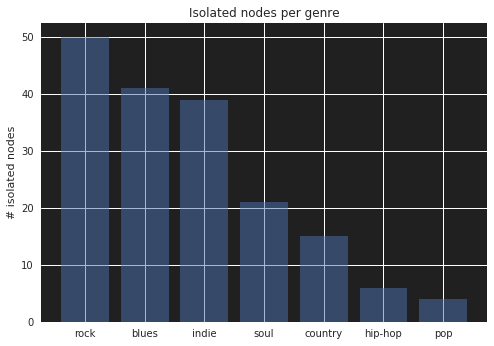

In [542]:
#Plot chart of isolated nodes per genre
isolatedGenres = obtainGenresOfIsolatedNodes(G)
plotBarChartFromDict(isolatedGenres)

With the information retrieved we can say that the genre with more artists without colaborations is *rock*. Fifty artists of the rock genre has no colaborations, which means that the 50% of the artists of genre rock do not collaborate with other artists. This measure is quite significant to determine that rock artists tend to just perform their own music.

Rock genre is followed by blues and indie, which have arround 40 isolated artists. While, on the other side, pop and hip-hop are the genres with less non-connected nodes. It means that around the 95% of the artists of both, pop and hip-hop genre have colaborated with at least one of the other top artists.


Afterwards, we wanted to analyze the connections created between nodes to confirm that the created graph made sense from the data used. As we created a directed graph, first, both in and out degrees, both with weight and without it, have been analyzed.

In [0]:
def calculateInAndOutgoingDegree(G, weightTrue=False): 
    inoutgoingDegreeDict = dict()
    count = 0
    countIn = 0
    countOut = 0
    for node in G.nodes:
      if(weightTrue):
        inD = G.in_degree(node, weight='weight')
        outD = G.out_degree(node, weight='weight')
      else:
        inD = G.in_degree(node)
        outD = G.out_degree(node)
      pred = list(G.predecessors(node))
      succ = list(G.successors(node))
      inoutgoingDegreeDict[node] = [[inD,pred],[outD,succ]]
      if (inD == outD):
        count+=1
      elif (inD > outD):
        countIn +=1
      elif (outD > inD):
        countOut +=1
    return count, countIn, countOut, inoutgoingDegreeDict

In [544]:
#Analysis of in and out degrees without analysing the weight of the connections
counter, counterIn, counterOut, inoutgoingDegreeDict = calculateInAndOutgoingDegree(G, False)
print("Number of artists that have the same in and out degree: ", counter)
print("Number of artists that have bigger out than in degree: ", counterOut)
print("Number of artists that have bigger in than out degree: ", counterIn)

#Show Ed Sheran example
example = inoutgoingDegreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("6eUKZXaKkcviH0Ku9w2n3V"))+list(G.successors("6eUKZXaKkcviH0Ku9w2n3V")))))

#Show Drake example
example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("3TVXtAsR1Inumwj472S9r4"))+list(G.successors("3TVXtAsR1Inumwj472S9r4")))))

#Show Hillsong United example
example = inoutgoingDegreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("74cb3MG0x0BOnYNW1uXYnM"))+list(G.successors("74cb3MG0x0BOnYNW1uXYnM")))))

Number of artists that have the same in and out degree:  224
Number of artists that have bigger out than in degree:  179
Number of artists that have bigger in than out degree:  206
Ed Sheran example: 
	 In Degree -  4
	 Out Degree -  2
	 Different nodes -  5
Drake example: 
	 In Degree -  39
	 Out Degree -  27
	 Different nodes -  47
Hillsong United example: 
	 In Degree -  1
	 Out Degree -  1
	 Different nodes -  1


In [545]:
#Analysis of in and out degrees with analysis of the weight of the connections
counter, counterIn, counterOut, inoutgoingDegreeDict = calculateInAndOutgoingDegree(G, True)
#Show Ed Sheran example
example = inoutgoingDegreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

#Show Drake example
example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

#Show Hillsong United example
example = inoutgoingDegreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

Ed Sheran example: 
	 In Degree -  149
	 Out Degree -  2
	 Total -  151
Drake example: 
	 In Degree -  8253
	 Out Degree -  9510
	 Total -  17763
Hillsong United example: 
	 In Degree -  14843
	 Out Degree -  14843
	 Total -  29686


Thanks to the network created, we wanted to analyze if the data obtained from Spotify was completed and how it was structured. More concretely, we were wondering if one artist that colaborated on a song with another artist, then that song was retrieved on the list songs of both artists or not. More concretely, we wanted to check if the data of all songs was repeated or, otherwise, more preprocess related with the songs of each artists should be done. 

With the results retrieved, we realised that just 224 nodes out of 609 had the same number of in and out degrees. And we also realised that the predessessors and successors nodes were not even the same ones.

Taking it into account we figured out that Spotify API didn't return a complete list of artists per song so we should put more focus on the creation of our network to try to avoid to count one song multiple times on the colaboration of the songs. Having found this format on the saved information, we had a deep look on the information saved and we decided to change our approach on the creation of the colaborations network. We though that it was better to create an *undirected graph* with the following characteristics:

* Node : Artist inside the top 100 of each genre
    * Name attribute for each node
* Edge : Colaboration between artists
    * Edge weight : Number of times that they have colaborated in different songs

To be able to achieve it and with other considerations found on the data downloaded, the following preprocess to the data was needed to finally create the network of colaborations.


*  Delete all detected self-collaborations that are created due to typos.

*  Include just the collaborations between the top 100 artists of all genres defined.

*  Do not include duplicated songs, as we detected that there are songs duplicated with different id's.

So, as we have realized that the directed graph may not be the best solution for representing our dataset, e have created instead an undirected graph by taking into account the title of the songs to avoid the replicated ones. This way, we are avoiding the duplicated songs as we realized that spotify give different unique identifiers to same songs that belong to different country markets. So, avoiding the duplicated songs by title, the information represented on our network will be more accurate because we made sure that each song with more than one artist was just added once in our network.

In [0]:
#Delete self-collaborations due to typos
colaborationsListAlbums = colaborationsListAlbums[colaborationsListAlbums['Artist_id']!=colaborationsListAlbums['ArtistColab_id']]
colaborationsListSingles = colaborationsListSingles[colaborationsListSingles['Artist_id']!=colaborationsListSingles['ArtistColab_id']]
frames = [colaborationsListAlbums,colaborationsListSingles]
colaborationsList = pd.concat(frames)

In [0]:
# Define an empty undirected graph
GU = nx.Graph()

In [0]:
#Delete duplicated songs by title
def deleteDuplicatedSongs(artistsColabs):
  df = artistsColabs.drop_duplicates(['Artist_id','ArtistColab_id','Song'])
  return df

In [0]:
#Create a dictionary with all colaborations for each artist (Key:Artist, Values:List of artists and number of colaborations done)
artistsColabDict = dict()
#Create a dictionary of songs per artist (Key:Artist, Values:List of songs)
artistsSongs = dict()

#Iterate for the list of artists
for artist in artistsList.iterrows():
      
    #Create a node and the attributes for each artist
    GU.add_node(artist[1]['Artist_id'])
    nx.set_node_attributes(GU, {artist[1]['Artist_id']: {"Name": artist[1]['Artist']}})
  
    #Keep the information about the colaboration created inside the artistsColabDict
    #If the information for that artist is already on the dict we skip it
    if (artistsColabDict.get(artist[1]['Artist_id']) is None):
      #Create the collaborationsList
      #Find all the artists that have colaborated with current artist
      #And count the number of collaborations done with each artist
      artistsColabs = colaborationsList[colaborationsList['Artist_id'] == artist[1]['Artist_id']]
      artistsColabs = artistsColabs[artistsColabs['ArtistColab_id'].isin(artistsList.Artist_id.values)]
      artistsColab = colaborationsList[colaborationsList['ArtistColab_id'] == artist[1]['Artist_id']]

      #Delete duplicated songs from both dataframes
      artistsColabs = deleteDuplicatedSongs(artistsColabs)
      artistsColab = deleteDuplicatedSongs(artistsColab)

      if (len(artistsColab)>0 and len(artistsColabs)>0):
        #Take the list of unique values from each dataframe
        songsColab = artistsColab.Song.unique()
        songsColabs = artistsColabs.Song.unique()
        #Create a unique list of songs from both lists of colaborations
        songs = np.unique(np.concatenate([songsColab,songsColabs]))
        artistsSongs[artist[1]['Artist_id']] = list(songs)
        #Take just the songs that are not included on the other dataframe
        artistsColabs = artistsColabs[~artistsColabs["Song"].isin(artistsColab.Song.values)]
        #Join both dataframes
        frames = [artistsColabs.ArtistColab_id, artistsColab.Artist_id]
        artistsColabConcate = pd.concat(frames)
      elif(len(artistsColab)>0):
        #Take the list of unique songs
        artistsSongs[artist[1]['Artist_id']] = list(artistsColab.Song.unique())
        artistsColabConcate = artistsColab.Artist_id
      elif(len(artistsColabs)>0):
        #Take the list of unique songs
        artistsSongs[artist[1]['Artist_id']] = list(artistsColabs.Song.unique())
        artistsColabConcate = artistsColabs.ArtistColab_id
      else:
        #Create an empty list
        artistsSongs[artist[1]['Artist_id']] = []
        artistsColabConcate = pd.DataFrame()
      #Count the number of colaborations for each other artist
      uniqueColabs = Counter(artistsColabConcate.values)
      #Add the information to the artistsColabDict
      artistsColabDict[artist[1]['Artist_id']] = uniqueColabs

      #Add all colaborations to the network
      for artistColab in uniqueColabs.items():
          #Create the link and set the number of retweets to that member as the weight of the relation
          GU.add_edge(artist[1]['Artist_id'], artistColab[0], weight=artistColab[1])

In [550]:
#Check useful information of the netwotk created
print("Number of nodes", len(GU.nodes))
print("Number of edges", len(GU.edges))
print("Number of isolated nodes", len(list(nx.isolates(GU))))

Number of nodes 609
Number of edges 2163
Number of isolated nodes 160


Once the new network is created, it can be seen that the network contains again 609 nodes. But now the number of edges has been reduced to 2163 because the new created graph is undirected and then it just exists one unique edge between two nodes. And the number of isolated nodes has been increased to 160 due to the elimination of the self-colaborations due to type.

So, we can say again that the **26,2%** of the artists of our network do not have colaborations and the mean of number of artists with which an artist has colaborated is **3,5**.

And then we just check again the isolated nodes per genre using a bar chart plot.

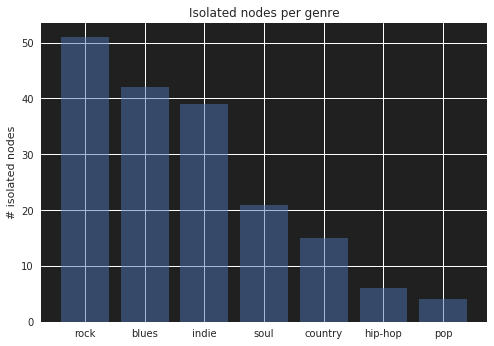

In [551]:
#Plot chart of isolated nodes per genre
isolatedGenres = obtainGenresOfIsolatedNodes(GU)
plotBarChartFromDict(isolatedGenres)
#Same as before but just to check

With the displayed plot, we can see that the two new isolated artists belong to rock genre. During the next section we will provide more information about one of these two artists, by giving evidence on the differences created.

Furthermore, we wanted to also analyze again, the connections created between nodes. As now we have created a undirected graph, just the degree can be analyzed. The general degree and the weighted degree have been retrieved for two artists examples.

In [0]:
#Obtains the degree and the neighbours for all nodes
def calculateDegree(GU, weightTrue = False): 
    degreeDict = dict()
    count = 0
    for node in GU.nodes:
      if (weightTrue):
        deg = GU.degree(node, weight='weight')
      else:
        deg = GU.degree(node)
      neig = list(GU.neighbors(node))
      degreeDict[node] = [deg,neig]
    return count, degreeDict

In [553]:
#Now the number of colabs are checked
count, degreeDict = calculateDegree(GU, True)

#Show Ed Sheran example
example = degreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

#Show Drake example
example = degreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

#Show Hillsong United example
example = degreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

Ed Sheran example: 
	 Degree -  9
	 Neigh -  5
Drake example: 
	 Degree -  170
	 Neigh -  47
Hillsong United example: 
	 Degree -  0
	 Neigh -  0


With the results retrieved, we can see that the number of neigbours and the number of weighted nodes is not the same one. Moreover, comparing the results with the ones obtained before, it can be realized that the number of colaborations that each artist has have decreased considerably. But the number of distinct neighbours remains the same.

Then, after checking the information contained on the files used to upload the data, we realized that Spotify API retrieved quite a lot of repeated songs for each artist. So the filter that we added during the creation of our network was really needed to do not include repeated collaborations. Furthermore, we found an interesting example for the self-colaborations removed. More concretely, we realized that the group *Hillsong United* had many self-colaborations as Spotify API retrieved sometimes their name with different capital letters (e.g. Hillsong UNITED instead of Hillsong United). So we can see that in our current network that *Hillsong United* is an isolated node as it is not connected to any other node, while before it had one conection and 14843 colaborations assigned.

So we belive that at this point we have been able to create a network which represents the colaborations between the different artists but we want to plot the network created to see if we can extract more information from it.

We have used 

In [0]:
#Obtain the undirected version of the previous network created
def createUndirectGraph(G):
    G_und = G.to_undirected()
    return G_und

In [0]:
#Set the parameters for the Force Atlas Algorithm
def setForceAtlasParameters():
    forceatlas2 = ForceAtlas2(
                              # Behavior alternatives
                              outboundAttractionDistribution=True,  # Dissuade hubs
                              linLogMode=False,  # NOT IMPLEMENTED
                              adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                              edgeWeightInfluence=0.1,

                              # Performance
                              jitterTolerance=250.0,  # Tolerance
                              barnesHutOptimize=False,
                              barnesHutTheta=2.0,
                              multiThreaded=False,  # NOT IMPLEMENTED

                              # Tuning
                              scalingRatio=30.0,
                              strongGravityMode=False,
                              gravity=170.0,

                              # Log
                              verbose=False)
    return forceatlas2

In [0]:
#Calculate the nodes coordinates using the Force Atlas Algorithm
def calculateCoordinatesUsingForceAtlas(G_und, forceatlas2):
    positions = forceatlas2.forceatlas2_networkx_layout(G_und, pos=None, iterations=3000)
    return positions

In [0]:
#Calculate node sizes according to the given mode
def calculateSizeOfNodes(mode,G,nodes):
    if (mode == "degrees"):
        #Set nodes' size according to their degree
        deg = nx.degree(G)
        sizes = [deg[node]*5 for node in nodes]
    if (mode == "degreesWeigth"):
        #Set nodes' size according to their degree
        deg = nx.degree(G, weight='weight')
        sizes = [deg[node]*2 for node in nodes]
    if (mode == "betweenness_centrality"):
        #Set nodes' size proportional to their betweenness centrality
        between_res = nx.betweenness_centrality(G, weight='weight')
        sizes = [between_res[node]*30000 for node in nodes]
    if (mode == "closeness_centrality"):
        #Set nodes' size proportional to their closeness centrality
        between_res = nx.closeness_centrality(G)
        sizes = [between_res[node]*300 for node in nodes]
    if (mode == "eigenvector_centrality"):
        #Set nodes' size proportional to their eigenvector centrality
        eigen_res = nx.eigenvector_centrality(G, weight='weight')
        sizes = [eigen_res[node]*5000 for node in nodes]
    return sizes

In [0]:
#Calculate node colors according to the given mode
def calculateColorsOfNodes(mode,G,nodes):
  colors = []
  if(mode == "full_graph"):
    #Set node colors according to their party (blue for democratic and red for republicans)
    for n in nodes:
      ['pop','rock','hip-hop','blues','indie','country','soul']
      if (genre_dict[n] == ['pop']):
        pop_patch = mpatches.Patch(color='#4abdac', label='Pop Nodes', facecolor = 'white')
        colors.append("#4abdac")#fresh green
      elif(genre_dict[n] == ['rock']):
        rock_patch = mpatches.Patch(color='#fc4a1a', label='Rock Nodes')
        colors.append("#fc4a1a")#vermillion red
      elif(genre_dict[n] == ['hip-hop']):
        hip_hop_patch = mpatches.Patch(color='#f7b733', label='Hip Hop Nodes')
        colors.append("#f7b733")#sunshine
      elif(genre_dict[n] == ['blues']):
        blues_patch = mpatches.Patch(color='#0375b4', label='Blues Nodes')
        colors.append("#0375b4")#starry night blue
      elif(genre_dict[n] == ['indie']):
        indie_patch = mpatches.Patch(color='#007849', label='Indie Nodes')
        colors.append("#007849")#irises green
      elif(genre_dict[n] == ['country']):
        country_patch = mpatches.Patch(color='#e37222', label='Country Nodes')
        colors.append("#e37222")#country tangerine
      elif(genre_dict[n] == ['soul']):
        soul_patch = mpatches.Patch(color='#07889b', label='Soul Nodes')
        colors.append("#07889b")#teal blue
      else:
        mixt_patch = mpatches.Patch(color='#FFFFFF', label='Mixt Nodes')
        colors.append("#FFFFFF")#teal blue
    leg = plt.legend(handles=[pop_patch, rock_patch, hip_hop_patch, blues_patch, indie_patch, country_patch, soul_patch, mixt_patch], fontsize = 15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
  return colors

In [0]:
#Visualize the network of retweets of all members of the house of 2015
def drawNetwork(mode,G,G_und,positions,title):
    #Define figure size
    plt.figure(3,figsize=(17,12))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#202020"
    plt.title(title, fontsize=20)
    plt.rcParams['font.family'] = 'Verdana'
    # Hide grid lines
    plt.grid(False)
    # Hide axes ticks
    plt.xticks([])
    plt.yticks([])
    #Obtain list of nodes of the graph
    nodes = nx.nodes(G_und)
    
    #Calculate node sizes according to the given mode
    sizes = calculateSizeOfNodes(mode,G,nodes)
    #Calculate node colors according to the given mode
    colors = calculateColorsOfNodes('full_graph',G_und,nodes)
    #colors = calculateColorsOfNodes(mode,G_und,nodes)

    #Plot created network
    nx.draw_networkx(G_und, positions, nodelist=nodes, cmap=plt.get_cmap('jet'), width=0.4, with_labels=False, node_size=sizes, node_color=colors, edge_color="#a0a0a0")
    plt.show()

In [0]:
#Visualize subgraph
#node = GU.nodes("6eUKZXaKkcviH0Ku9w2n3V")
#neigh = GU.neighbors("6eUKZXaKkcviH0Ku9w2n3V")
#print(len(list(neigh)))
#Show Drake example
#example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]

#H = G.subgraph(nodes)
#nx.draw_networkx(H)

In [0]:
#Visualize the network 
G_und = createUndirectGraph(G)
forceatlas2 = setForceAtlasParameters()
positions = calculateCoordinatesUsingForceAtlas(G_und,forceatlas2)

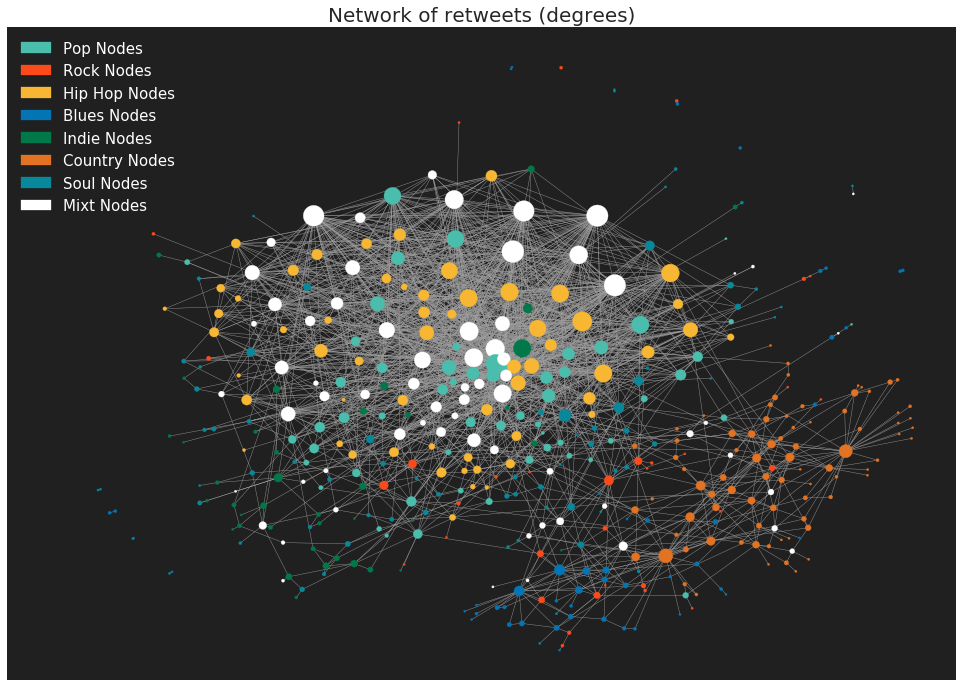

In [562]:
drawNetwork("degrees", G , G_und, positions, 'Network of retweets (degrees)')

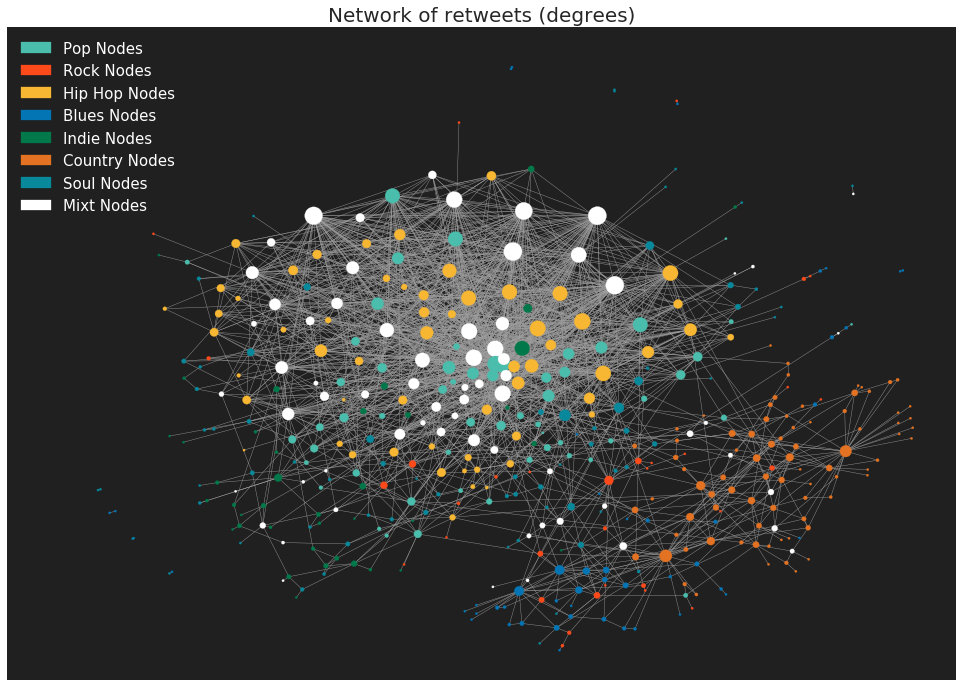

In [563]:
#Visualize the undirected network
drawNetwork("degrees", GU , GU, positions, 'Network of retweets (degrees)')

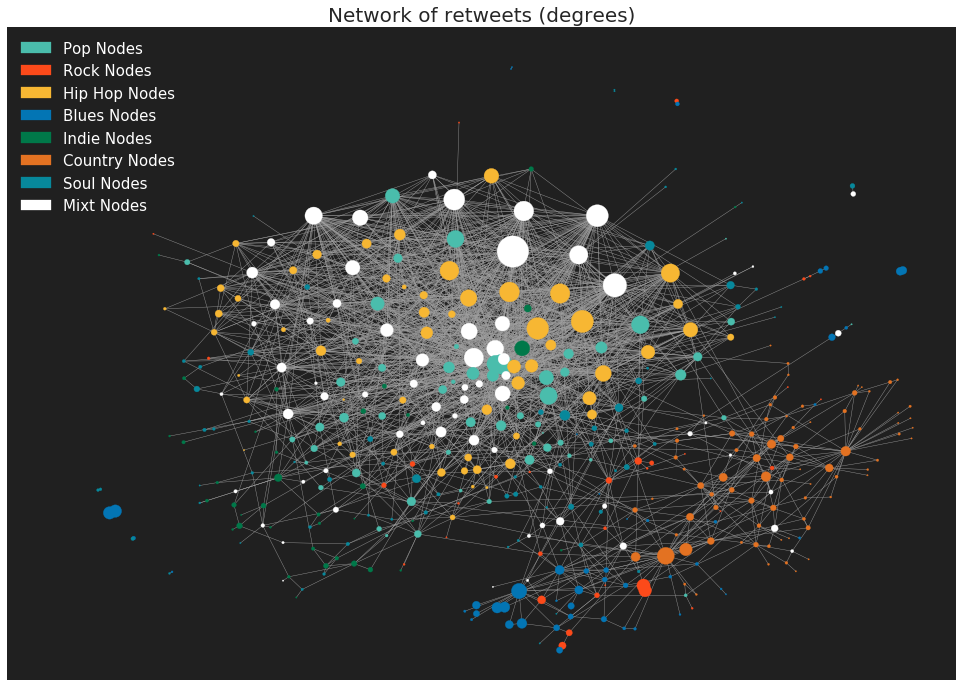

In [564]:
#Visualize the undirected network
drawNetwork("degreesWeigth", GU , GU, positions, 'Network of retweets (degrees)')

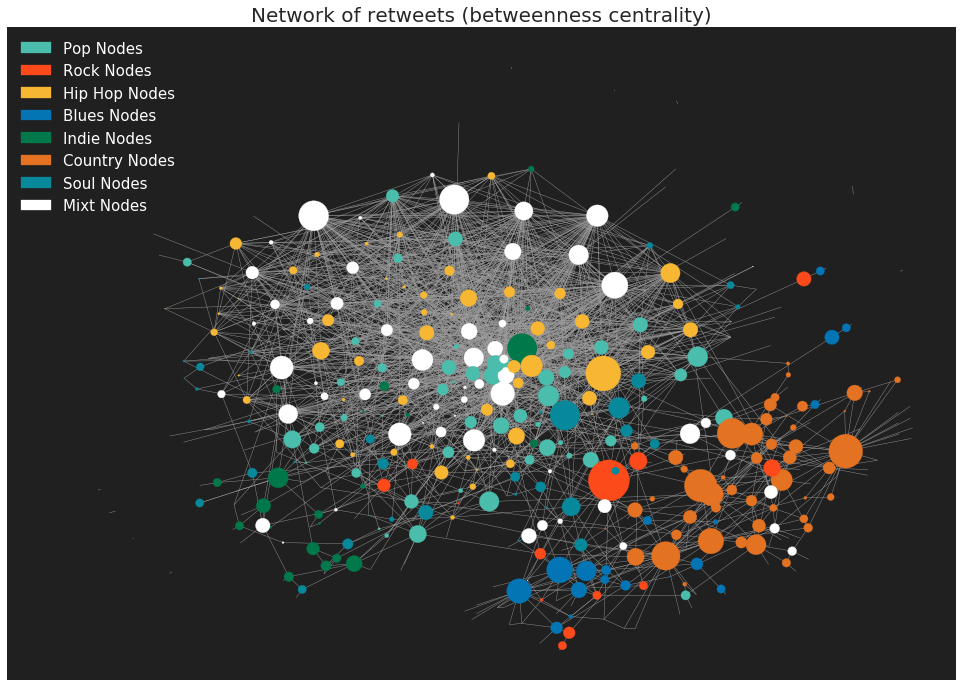

In [565]:
#Visualize the network with nodes' size proportional to their betweenness centrality
drawNetwork("betweenness_centrality", GU , GU, positions, 'Network of retweets (betweenness centrality)')

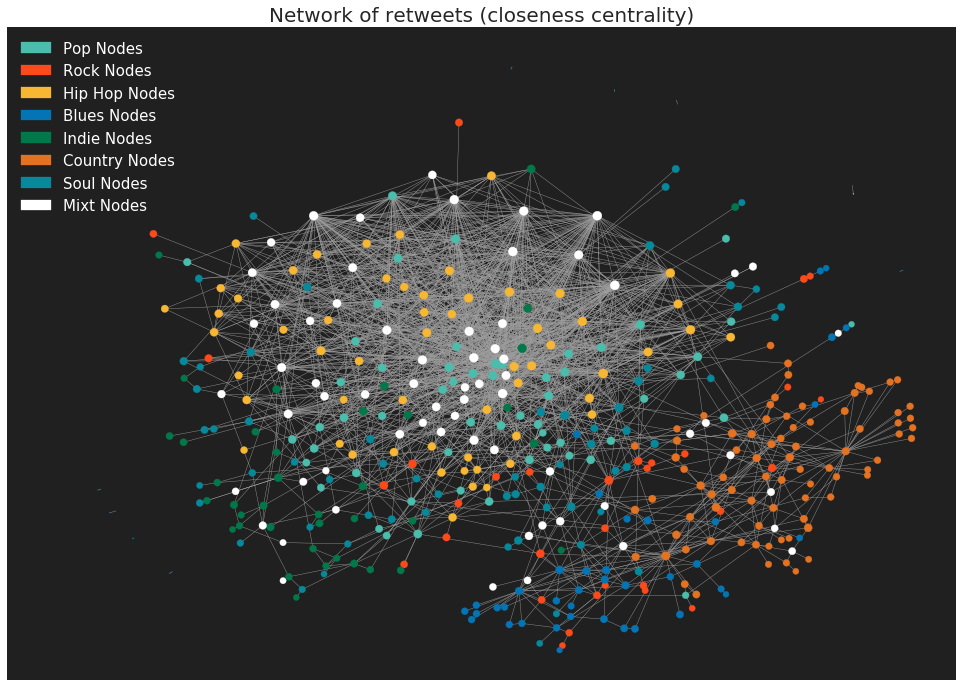

In [566]:
#Visualize the network with nodes' size proportional to their closeness centrality
drawNetwork("closeness_centrality", GU , GU, positions, 'Network of retweets (closeness centrality)')

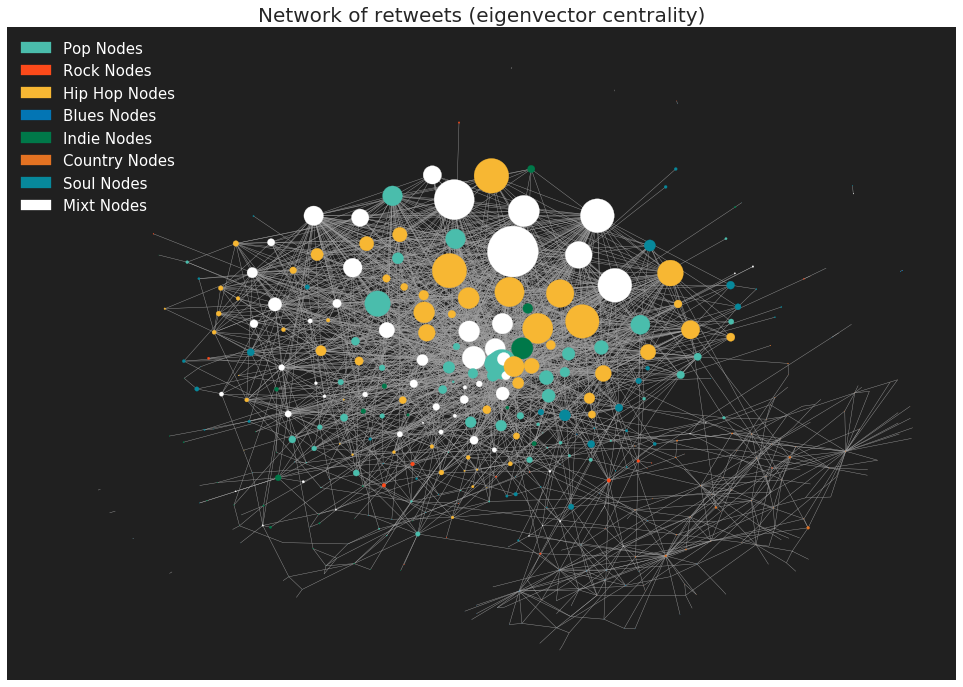

In [567]:
 #Visualize the network with nodes' size proportional to their eigenvector centrality
drawNetwork("eigenvector_centrality", GU , GU, positions, 'Network of retweets (eigenvector centrality)')

In [0]:
#Print the top 3 values calculated for each genre
def printResultsTop3(mode, results_dict):
    #print(results_dict)
    for res in results_dict.items():
      gen = res[0]
      resList = res[1]
      print("\nThe top 3 nodes with highest " + mode + " within "+ gen +" artists are:")
      for member in resList[:3]:
        print(G.node[member[0]]['Name'] +": "+str(member[1]))

In [0]:
#Print 3 top members of each party according to the given mode
def printTopMembers(mode,G): 

    #Define empty lists
    results_dict = dict()
    if (mode == "degrees"):
        #Calculate the degree of the nodes
        values = nx.degree(G)
    if (mode == "degreesWeight"):
        #Calculate the degree of the nodes
        values = nx.degree(G, weight='weight')
    if (mode == "betweenness centrality"):
        #Calculate the betweenness centrality of the nodes
        values = nx.betweenness_centrality(G, weight='weight').items()
    if (mode == "eigenvector centrality"):
        #Calculate the eigenvector centrality of the nodes
        values = nx.eigenvector_centrality(G, weight='weight').items()

    #Sort the nodes according to he values calculated
    values_res_sort = sorted(values, key=lambda kv: kv[1], reverse=True)
    
    #Separate the all values calculated according to the party of the member 
    for node in values_res_sort:
        artistGenre = genre_dict.get(node[0])
        #print(artistGenre)
        for gen in artistGenre:
          genreResults = results_dict.get(gen)
          if genreResults is None:
            results_dict[gen] = [node]
          else:
            results_dict[gen].append(node)
    printResultsTop3(mode, results_dict)

In [570]:
#Obtain the three nodes with highest degree, degree weigth, eigenvector centrality and betweenness centrality within each party
printTopMembers("degrees", GU)
#printTopMembers("betweenness centrality")
#printTopMembers("eigenvector centrality")


The top 3 nodes with highest degrees within pop artists are:
Future: 66
Gucci Mane: 66
Lil Wayne: 65

The top 3 nodes with highest degrees within hip-hop artists are:
Future: 66
Gucci Mane: 66
Lil Wayne: 65

The top 3 nodes with highest degrees within indie artists are:
Wale: 43
G-Eazy: 31
Khalid: 29

The top 3 nodes with highest degrees within country artists are:
Willie Nelson: 30
Colt Ford: 27
Brad Paisley: 16

The top 3 nodes with highest degrees within soul artists are:
John Legend: 26
Mary J. Blige: 20
Alicia Keys: 14

The top 3 nodes with highest degrees within blues artists are:
Eric Clapton: 18
B.B. King: 18
Ray Charles: 11

The top 3 nodes with highest degrees within rock artists are:
Elton John: 16
Fall Out Boy: 11
Imagine Dragons: 10


In [571]:
#Obtain the three nodes with highest degree, eigenvector centrality and betweenness centrality within each party
printTopMembers("degreesWeight", GU)


The top 3 nodes with highest degreesWeight within pop artists are:
Gucci Mane: 494
Lil Wayne: 276
Future: 242

The top 3 nodes with highest degreesWeight within hip-hop artists are:
Gucci Mane: 494
Lil Wayne: 276
Rick Ross: 247

The top 3 nodes with highest degreesWeight within country artists are:
Willie Nelson: 145
Waylon Jennings: 79
George Strait: 47

The top 3 nodes with highest degreesWeight within blues artists are:
Eric Clapton: 118
Janis Joplin: 78
Big Brother & The Holding Company: 78

The top 3 nodes with highest degreesWeight within indie artists are:
Wale: 114
Jeremih: 66
Anderson .Paak: 54

The top 3 nodes with highest degreesWeight within rock artists are:
Tom Petty: 88
Tom Petty and the Heartbreakers: 80
The Rolling Stones: 33

The top 3 nodes with highest degreesWeight within soul artists are:
John Legend: 51
Jamie Foxx: 43
NxWorries: 35


In [572]:
def topArtistByColSongs(mode, artistsSongs):
    #Define empty lists
    results_dict = dict()
    #Sort the nodes according to he values calculated
    values_res_sort = sorted(artistsSongs.items(), key=lambda kv: len(kv[1]), reverse=True)
    #Separate the all values calculated according to the party of the member 
    for node in values_res_sort:
        artistGenre = genre_dict.get(node[0])
        #print(artistGenre)
        for gen in artistGenre:
          genreResults = results_dict.get(gen)
          if genreResults is None:
            results_dict[gen] = [(node[0],len(node[1]))]
          else:
            results_dict[gen].append((node[0],len(node[1])))
    printResultsTop3(mode, results_dict)
topArtistByColSongs("Songs", artistsSongs)


The top 3 nodes with highest Songs within pop artists are:
Gucci Mane: 461
Lil Wayne: 257
Future: 218

The top 3 nodes with highest Songs within hip-hop artists are:
Gucci Mane: 461
Lil Wayne: 257
Rick Ross: 219

The top 3 nodes with highest Songs within country artists are:
Willie Nelson: 141
Waylon Jennings: 78
Colt Ford: 47

The top 3 nodes with highest Songs within blues artists are:
Eric Clapton: 119
Janis Joplin: 78
Big Brother & The Holding Company: 78

The top 3 nodes with highest Songs within indie artists are:
Wale: 102
Jeremih: 63
Anderson .Paak: 52

The top 3 nodes with highest Songs within rock artists are:
Tom Petty: 88
Tom Petty and the Heartbreakers: 80
The Rolling Stones: 33

The top 3 nodes with highest Songs within soul artists are:
John Legend: 51
Jamie Foxx: 39
NxWorries: 35


In [573]:
printTopMembers("betweenness centrality", GU)


The top 3 nodes with highest betweenness centrality within rock artists are:
Elton John: 0.05618034419817423
Florida Georgia Line: 0.013080983440806576
Paul McCartney: 0.010380730966670597

The top 3 nodes with highest betweenness centrality within hip-hop artists are:
Snoop Dogg: 0.04076877180464798
Ty Dolla $ign: 0.029793111534182386
Young Thug: 0.02892391115578903

The top 3 nodes with highest betweenness centrality within country artists are:
Colt Ford: 0.03817686159094518
Brad Paisley: 0.03524748743887196
Darius Rucker: 0.029852050915596482

The top 3 nodes with highest betweenness centrality within pop artists are:
Ty Dolla $ign: 0.029793111534182386
Young Thug: 0.02892391115578903
Lil Wayne: 0.023014944682621826

The top 3 nodes with highest betweenness centrality within soul artists are:
John Legend: 0.02922199586192181
Mary J. Blige: 0.014668398781684187
Anthony Hamilton: 0.011280088545491333

The top 3 nodes with highest betweenness centrality within indie artists are:
Wale:

In [574]:
printTopMembers("eigenvector centrality", GU)


The top 3 nodes with highest eigenvector centrality within pop artists are:
Gucci Mane: 0.5156893387255662
Young Thug: 0.3201795062872812
Lil Wayne: 0.22838254430120813

The top 3 nodes with highest eigenvector centrality within hip-hop artists are:
Gucci Mane: 0.5156893387255662
Young Thug: 0.3201795062872812
Young Dolph: 0.2401158774118845

The top 3 nodes with highest eigenvector centrality within indie artists are:
Wale: 0.09084269529100443
Jeremih: 0.033723988264909306
PARTYNEXTDOOR: 0.01936948369484586

The top 3 nodes with highest eigenvector centrality within soul artists are:
Jamie Foxx: 0.025572289961650584
John Legend: 0.024778291233953458
Kelly Rowland: 0.012692649366362413

The top 3 nodes with highest eigenvector centrality within rock artists are:
Fall Out Boy: 0.004147820556644076
X Ambassadors: 0.002984705370919689
Imagine Dragons: 0.002843585394483746

The top 3 nodes with highest eigenvector centrality within country artists are:
Brantley Gilbert: 0.0015999170190024

In [0]:
#Calculate the strength degree distribution for each genre (sum of the weight of links)
def calculateDegreeDistribution(GU): 
    degreeDistDict = dict()
    for node in GU.nodes:
      neighbors = GU.neighbors(node)
      count = 0
      for neigh in neighbors:
        count += GU.edges[(node,neigh)]['weight']
      artistGenre = genre_dict.get(node)
      for gen in artistGenre:
        genreResults = degreeDistDict.get(gen)
        if genreResults is None:
          degreeDistDict[gen] = [count]
        else:
          degreeDistDict[gen].append(count)   
    return degreeDistDict

In [0]:
#Calculate the strength degree distribution for each genre (sum of the weight of links)
def calculateDegreeDistribution1(GU): 
    degreeDistDict = dict()
    nodes = nx.degree(GU, weight='weight')
    for node in nodes:
      artistGenre = genre_dict.get(node[0])
      for gen in artistGenre:
        genreResults = degreeDistDict.get(gen)
        if genreResults is None:
          degreeDistDict[gen] = [node[1]]
        else:
          degreeDistDict[gen].append(node[1])
    return degreeDistDict

In [0]:
#Plot the outgoing strength distribution of each party (sum of the weight on outgoing links)
def showPlot(degreeDistDict):  
    plt.figure(3,figsize=(10,7))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#FFFFFF"
    colors = ['blue', 'red','green','orange','yellow','pink','brown' ]
    #Bin the degree distribution
    count = 0
    for outgoing in degreeDistDict.values():
      #x = list(nx.degree(G).values())
      histoDem, bin_edgesDem = np.histogram(outgoing)
      #histoDem, bin_edgesDem = np.histogram(outgoing, bins=range(max(outgoing)))
      histoDem = np.append(histoDem,0)
      plt.plot(bin_edgesDem,histoDem, color=colors[count])
      count += 1
    plt.legend(loc='upper right')
    plt.show()
    #Define the plot values and utilities
    #plt.plot(bin_edgesDem,histoDem, color="blue", label='Democrats')
    #plt.plot(bin_edgesRep,histoRep, color="red", label='Republicans')
    #Set backgroud color
    #plt.rcParams['axes.facecolor'] = "white"
    #Set labels
    #plt.ylabel('Weight on outgoing links')
    #plt.xlabel('Distribution')
    #Define legend
    #plt.legend(loc='upper right', fontsize=16)
    #plt.title('Outgoing strength distribution of each party', fontsize=20)
    #Show the defined plot
    #plt.show()

No handles with labels found to put in legend.


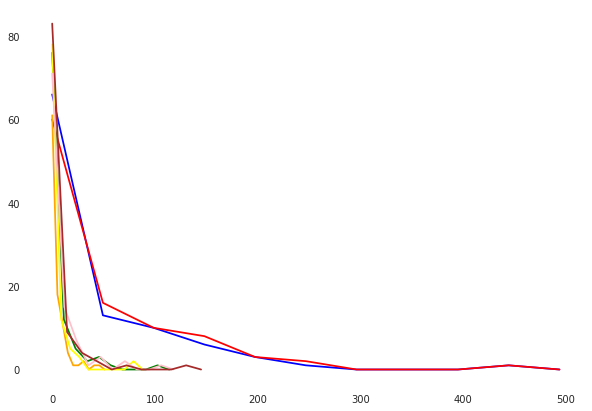

In [578]:
#Plot the distribution of outgoing strength for the republican and democratic nodes
degreeDistDict = calculateDegreeDistribution(GU)
showPlot(degreeDistDict)

No handles with labels found to put in legend.


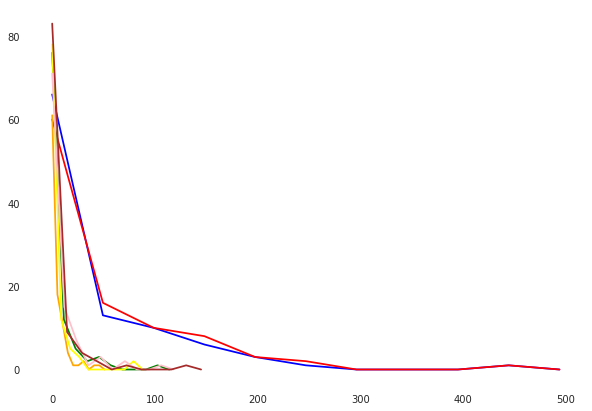

In [579]:
#Plot the distribution of outgoing strength for the republican and democratic nodes
degreeDistDict = calculateDegreeDistribution1(GU)
showPlot(degreeDistDict)

In [0]:
#Calculate the outgoing strength distribution for each genre (sum of the weight on outgoing links)
def calculateOutgoingDistribution(GU):
    degreeDistDict = dict()
    nodes = nx.degree(GU, weight='weight')
    for node in nodes:
      artistGenre = genre_dict.get(node[0])
      for gen in artistGenre:
        genreResults = degreeDistDict.get(gen)
        if genreResults is None:
          degreeDistDict[gen] = [(node[0],node[1])]
        else:
          degreeDistDict[gen].append((node[0],node[1]))
    return degreeDistDict

In [0]:
#Plot the outgoing strength distribution of each party (sum of the weight on outgoing links)
def showBarPlot(outgoingDistDict):  
    plt.figure(3,figsize=(15,10))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#FFFFFF"
    colors = ['blue', 'red','green','orange','yellow','pink','brown' ]
    #Bin the degree distribution
    count = 0
    for outgoing in outgoingDistDict.values():
      outgoing = sorted(outgoing, key=lambda tup: tup[1])
      objects = [x[0] for x in outgoing]
      y_pos = np.arange(len(outgoing))
      performance = [x[1] for x in outgoing]
      plt.bar(y_pos, performance, align='center', alpha=0.5,color=colors[count])
      #plt.xticks(y_pos, objects)
      plt.ylabel('Usage')
      plt.title('Programming language usage')
      count += 1
      plt.show()

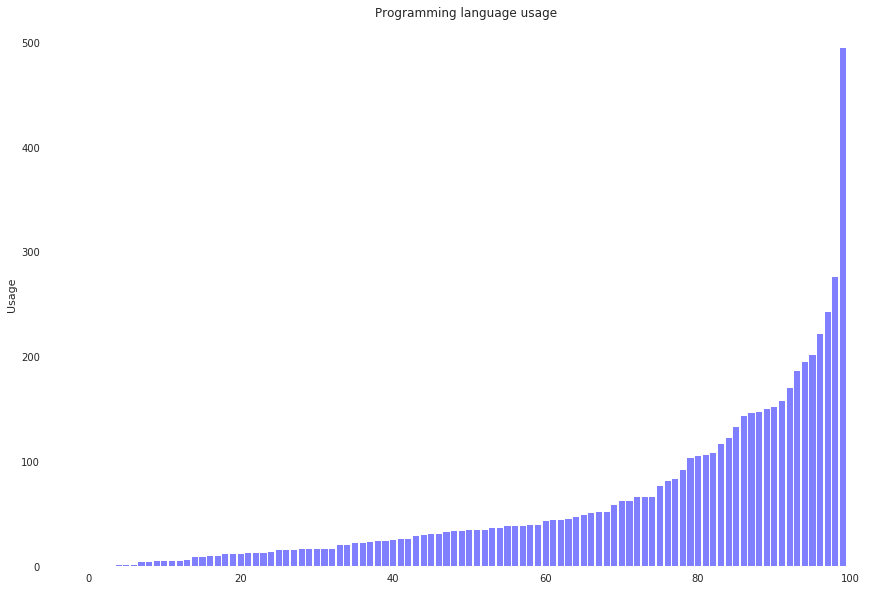

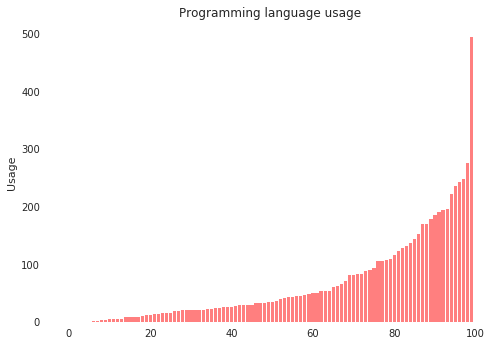

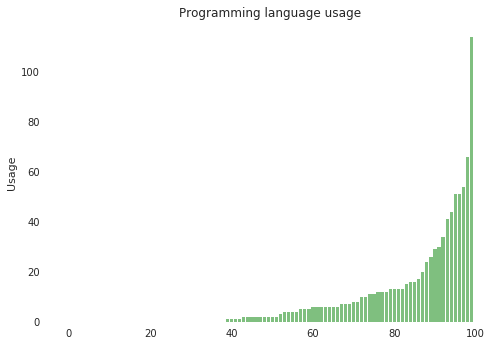

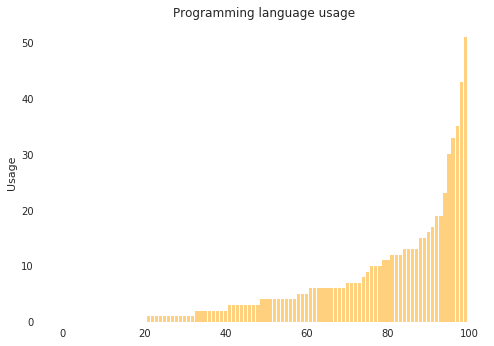

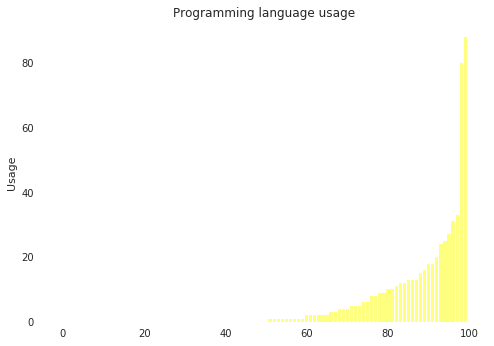

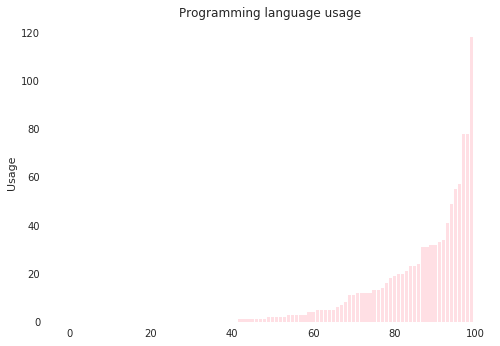

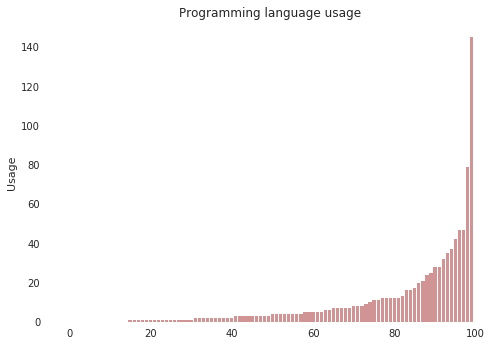

In [582]:
#Plot the distribution of outgoing strength for the republican and democratic nodes
outgoingDistDict = calculateOutgoingDistribution(GU)
showBarPlot(outgoingDistDict)

In [0]:
#Calculate the outgoing strength distribution for each party (sum of the weight on outgoing links)
def calculateTotalNumberOfColabsPerGenre(G):
    outgoingDistDict = dict()
    nodes = nx.degree(G, weight='weight')
    for node in nodes:
      artistGenre = genre_dict.get(node[0])
      for gen in artistGenre:
        genreResults = outgoingDistDict.get(gen)
        if genreResults is None:
          outgoingDistDict[gen] = node[1]
        else:
          outgoingDistDict[gen] += node[1]
    return outgoingDistDict

In [0]:
#Print the top 3 values calculated for each party
def printResultsColabs(results_dict):
    results_dict = sorted(results_dict.items(), key=lambda kv: -kv[1])
    for res in results_dict:
      print("\nThe total number of colaboration for the artists within "+ res[0] +" is:", res[1])

In [585]:
outgoingDistDict = calculateTotalNumberOfColabsPerGenre(GU)
printResultsColabs(outgoingDistDict)


The total number of colaboration for the artists within hip-hop is: 6676

The total number of colaboration for the artists within pop is: 5896

The total number of colaboration for the artists within blues is: 1049

The total number of colaboration for the artists within country is: 964

The total number of colaboration for the artists within indie is: 913

The total number of colaboration for the artists within soul is: 658

The total number of colaboration for the artists within rock is: 589


In [0]:
#Compute the communities of a graph using best partition
def computeCommunities(G_und):
    #first compute the best partition
    partition = community_louvain.best_partition(G_und)
    return partition
#Calculate the modularity of the algorithm
def calculateModularity(partition, G_und):
    modularity = community_louvain.modularity(partition, G_und)
    return modularity

In [587]:
#Find communities in the full house of representatives network
partition = computeCommunities(G_und)
#Calculate the modularity found by the previous algorithm
modularity = calculateModularity(partition, GU)
print("\nThe modularity calculated is: " + str(round(modularity,4)))


The modularity calculated is: 0.4392


In [0]:
#Visualize the network of retweets of all members of the house of 2015
def drawNetworkCommunities(G_und,positions, partition,title):
    #Define figure size
    plt.figure(3,figsize=(15,15))
    plt.title(title, fontsize=40)
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#FFFFFF"
    
    #Obtain list of nodes of the graph
    nodes = partition.keys()
    edges = G_und.edges
    
    #Calculate node colors according to community assigned
    colors= list(partition.values())
    #Plot created network
    nx.draw_networkx(G_und, positions, nodelist=nodes, edgelist=edges,cmap=plt.get_cmap('gist_ncar'), width=0.4, with_labels=False, node_size=50, node_color=colors,edge_color='grey')
    plt.show()

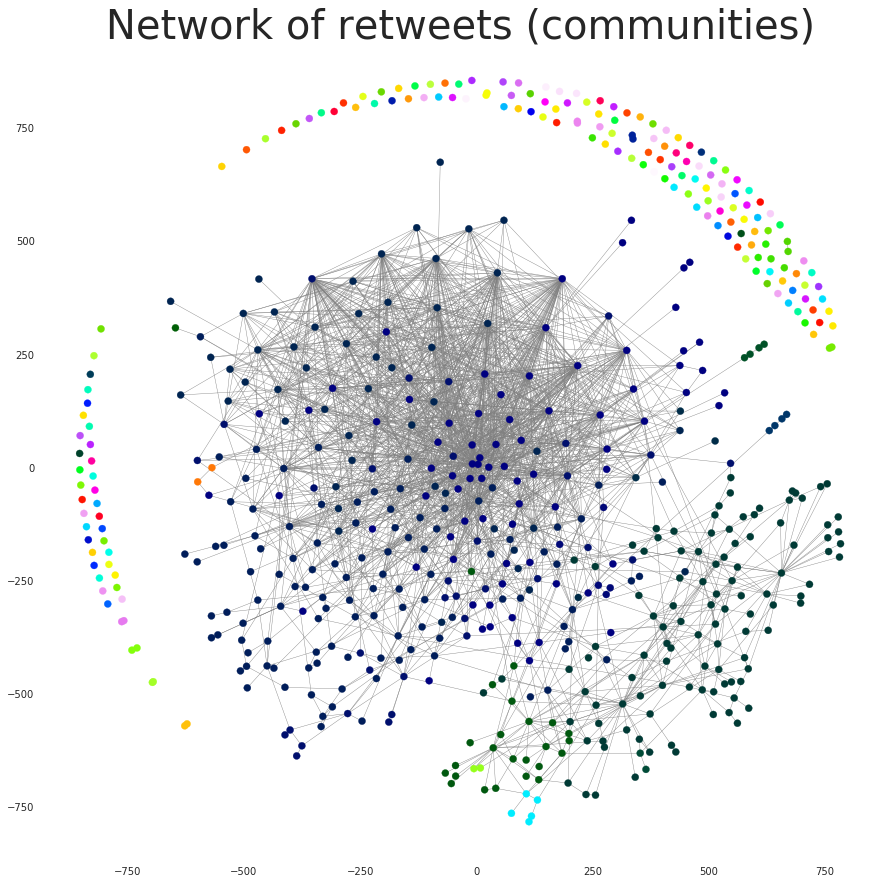

In [589]:
#Visualize the network with nodes' colors based on their community
drawNetworkCommunities(GU,positions, partition, 'Network of retweets (communities)')

In [0]:
#Compute the confusion matrix of the parties and communities of the network
def computeConfusionMatrix(G, partition):
    #Define the dimension of the D matrix
    confusion_matrix = np.zeros((7, len(set(partition.values()))))
    #Calculate the values of the D matrix defined
    for part in partition.items():
        #Check if the party of the node
        for gen in genre_dict[part[0]]:
          count = 0
          for g in genres:
            if (g==gen):
              confusion_matrix[count][part[1]] += 1
            count +=1
    return confusion_matrix

In [0]:
#Obtain the confusion matrix of the network of retweets
confusion_matrix = computeConfusionMatrix(GU, partition)

In [0]:
#Visualise the confusion matrix calculated of the parties and communities of the network
def plotConfusionMatrix(confusion_matrix):   
    plt.figure(3,figsize=(12,12))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#FFFFFF"
    #Plot the confusion matrix using interpolation to nearest
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('gist_stern'))
    #Set title
    plt.title('Confusion matrix', fontsize=20)
    #Show the defined plot
    plt.show()  

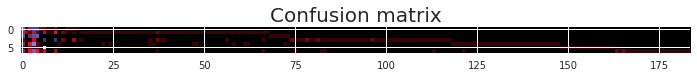

In [593]:
#Plot the confusion matrix
plotConfusionMatrix(confusion_matrix)
#print(confusion_matrix)

[Text(0,0.5,'pop'),
 Text(0,1.5,'rock'),
 Text(0,2.5,'hip-hop'),
 Text(0,3.5,'blues'),
 Text(0,4.5,'indie'),
 Text(0,5.5,'country'),
 Text(0,6.5,'soul')]

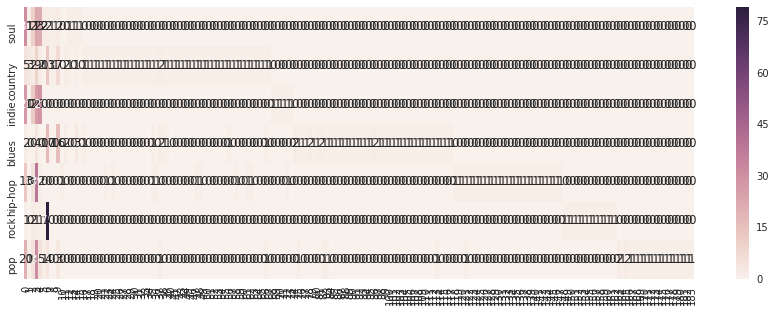

In [594]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
df_cm = pd.DataFrame(confusion_matrix)
sn.heatmap(df_cm, ax=ax, annot=True)
ax.set_yticklabels(genres)

In [0]:
def friendshipParadox(G, weightedTrue=False):
  count = 0
  flattenList = list(G.nodes)
  for i in range(1000):
      random_node = choice(flattenList)
      if(weightedTrue):
        nodDe = G.degree(random_node, weight='weight')
      else:
        nodDe = G.degree(random_node)
      neigh = [n for n in G.neighbors(random_node)]
      if(weightedTrue):
        neighDe = G.degree(neigh, weight='weight')
      else:
        neighDe = G.degree(neigh)
      values = [x[1] for x in neighDe]
      if (len(values)>1):
          neighmean = np.mean(values)
      elif (len(values)==1):
          neighmean = values[0]
      else:
          neighmean=0
      if nodDe < neighmean:
          count+=1 
  #     print "Num of node: ", nodDe, "- Avg. of its neighbors:", neighmean
  print("Friendship paradox has been true", count ,"times")


In [596]:
friendshipParadox(GU, False)

Friendship paradox has been true 610 times


In [597]:
friendshipParadox(GU, True)

Friendship paradox has been true 615 times


In [598]:
#Compute degree assortativity
nx.degree_assortativity_coefficient(GU)

0.2833011374443291

In [599]:
nx.degree_pearson_correlation_coefficient(GU)

0.2833011374443285

In [600]:
nx.average_neighbor_degree(GU, weight='weight')

{'00FQb4jTyendYWaN8pK0wa': 27.133333333333333,
 '00tVTdpEhQQw1bqdu8RCx2': 0.0,
 '01aC2ikO4Xgb2LUpf9JfKp': 7.75,
 '027TpXKGwdXP7iwbjUSpV8': 0.0,
 '02kJSzxNuaWGqwubyUba0Z': 20.477272727272727,
 '02rd0anEWfMtF7iMku9uor': 6.416666666666667,
 '02uYdhMhCgdB49hZlYRm9o': 0.0,
 '04ei5kNgmDuNAydFhhIHnD': 0.0,
 '04gDigrS5kc9YWfZHwBETP': 36.56,
 '0543y7yrvny4KymoaneT4W': 7.0,
 '06HL4z0CvFAxyc27GXpf02': 14.5,
 '06nsZ3qSOYZ2hPVIMcr1IN': 18.0,
 '070kGpqtESdDsLb3gdMIyx': 8.0,
 '07d5etnpjriczFBB8pxmRe': 21.533333333333335,
 '08GQAI4eElDnROBrJRGE0X': 0.0,
 '09C0xjtosNAIXP36wTnWxd': 0.0,
 '0A0FS04o6zMoto8OKPsDwY': 38.28915662650602,
 '0BvkDsjIUla7X0k6CSWh1I': 10.833333333333334,
 '0C0XlULifJtAgn6ZNCW2eu': 0.0,
 '0C8ZW7ezQVs4URX5aX7Kqx': 19.58823529411765,
 '0ECwFtbIWEVNwjlrfc6xoL': 0.0,
 '0FL2d6iFFNAV3yBUbXjZ1U': 0.0,
 '0FOWNUFHPnMy0vOw1siGqi': 33.38461538461539,
 '0GeeIVcvGA8GSlWsoY1dkG': 2.8333333333333335,
 '0H39MdGGX6dbnnQPt6NQkZ': 0.0,
 '0HU0U9kdXEHZVxUNbuQe8S': 0.0,
 '0JOxt5QOwq0czoJxvSc5hS': 27.17

In [601]:
nx.average_degree_connectivity(GU, weight='weight')

{0: 0,
 1: 6.491704374057315,
 2: 8.61890243902439,
 3: 10.453172205438067,
 4: 13.061181434599156,
 5: 14.989071038251366,
 6: 16.95528455284553,
 7: 19.045766590389015,
 8: 16.740909090909092,
 9: 14.273092369477911,
 10: 16.974025974025974,
 11: 21.407821229050278,
 12: 19.847619047619048,
 13: 23.272222222222222,
 14: 30.415384615384614,
 15: 29.807142857142857,
 16: 23.849740932642487,
 17: 38.448763250883395,
 18: 16.09961685823755,
 19: 38.782051282051285,
 20: 35.92063492063492,
 21: 30.0188679245283,
 22: 30.41269841269841,
 23: 30.82758620689655,
 24: 26.46524064171123,
 25: 33.53378378378378,
 26: 40.956989247311824,
 27: 24.135514018691588,
 28: 35.39622641509434,
 29: 17.686274509803923,
 30: 23.73076923076923,
 31: 31.566523605150216,
 32: 28.0,
 33: 40.63380281690141,
 34: 47.18518518518518,
 35: 38.02469135802469,
 38: 46.5,
 39: 38.28915662650602,
 42: 27.320987654320987,
 43: 38.110718492343935,
 44: 44.70918367346939,
 46: 29.796875,
 47: 40.78761061946903,
 48: 43.2

In [0]:
cliques = nx.enumerate_all_cliques(GU)
cliques4 = [clq for clq in cliques if len(clq)]

In [603]:
print(len(list(cliques4)))

121536


In [604]:
nx.graph_clique_number(GU)

12

In [605]:
nx.graph_number_of_cliques(GU)

2090

In [0]:
cliques = nx.find_cliques(GU)
cliques4 = [clq for clq in cliques if len(clq) >= 4]

In [607]:
print(len(list(cliques4)))

1252


In [0]:
#4856

In [609]:
nx.number_of_cliques(GU)

{'00FQb4jTyendYWaN8pK0wa': 3,
 '00tVTdpEhQQw1bqdu8RCx2': 1,
 '01aC2ikO4Xgb2LUpf9JfKp': 3,
 '027TpXKGwdXP7iwbjUSpV8': 1,
 '02kJSzxNuaWGqwubyUba0Z': 48,
 '02rd0anEWfMtF7iMku9uor': 8,
 '02uYdhMhCgdB49hZlYRm9o': 1,
 '04ei5kNgmDuNAydFhhIHnD': 1,
 '04gDigrS5kc9YWfZHwBETP': 15,
 '0543y7yrvny4KymoaneT4W': 1,
 '06HL4z0CvFAxyc27GXpf02': 4,
 '06nsZ3qSOYZ2hPVIMcr1IN': 1,
 '070kGpqtESdDsLb3gdMIyx': 1,
 '07d5etnpjriczFBB8pxmRe': 10,
 '08GQAI4eElDnROBrJRGE0X': 1,
 '09C0xjtosNAIXP36wTnWxd': 1,
 '0A0FS04o6zMoto8OKPsDwY': 145,
 '0BvkDsjIUla7X0k6CSWh1I': 4,
 '0C0XlULifJtAgn6ZNCW2eu': 1,
 '0C8ZW7ezQVs4URX5aX7Kqx': 8,
 '0ECwFtbIWEVNwjlrfc6xoL': 1,
 '0FL2d6iFFNAV3yBUbXjZ1U': 1,
 '0FOWNUFHPnMy0vOw1siGqi': 9,
 '0GeeIVcvGA8GSlWsoY1dkG': 2,
 '0H39MdGGX6dbnnQPt6NQkZ': 1,
 '0HU0U9kdXEHZVxUNbuQe8S': 1,
 '0JOxt5QOwq0czoJxvSc5hS': 2,
 '0L8ExT028jH3ddEcZwqJJ5': 1,
 '0NWbwDZY1VkRqFafuQm6wk': 92,
 '0ONHkAv9pCAFxb0zJwDNTy': 107,
 '0OpWIlokQeE7BNQMhuu2Nx': 24,
 '0PFtn5NtBbbUNbU9EAmIWF': 1,
 '0PxzGnCYBpSuaI49OR94cA': 1,
 

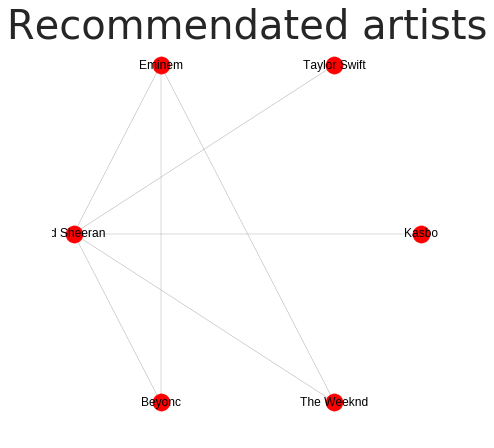

In [610]:
import matplotlib
#7tYKF4w9nC0nq9CsPZTHyP
cliques = nx.cliques_containing_node(GU,['6eUKZXaKkcviH0Ku9w2n3V'])
for item in cliques.items():
  result = set(x for l in item[1] for x in l)
  h = GU.subgraph(result)
  cliques_names = {k:v for k, v in names_dict.items() if k in h}
  forceatlas2 = setForceAtlasParameters()
  positions = calculateCoordinatesUsingForceAtlas(h,forceatlas2)
  
  plt.figure(3,figsize=(7,7))
  #Set backgroud color
  plt.rcParams['axes.facecolor'] = "#202020"
  plt.title("Recommendated artists", fontsize=40)
  #Obtain list of nodes of the graph
  nodes = nx.nodes(h)
  nx.draw_circular(h, nodelist=nodes, labels=cliques_names, with_labels = True,cmap=plt.get_cmap('jet'), width=0.4, edge_color="#a0a0a0")
  plt.show()
  
  #Calculate node colors according to the given mode
  #colors = calculateColorsOfNodes('full_graph',G_und,nodes)

    #Plot created network
    #nx.draw_networkx(G_und, positions, nodelist=nodes, cmap=plt.get_cmap('jet'), width=0.4, with_labels=False, node_size=sizes, node_color=colors, edge_color="#a0a0a0")
    

In [611]:
dict_of_cliques=nx.cliques_containing_node(GU,nodes=None)
print(dict_of_cliques)

{'3TVXtAsR1Inumwj472S9r4': [['3fMbdgg4jU18AjLCKBhRSm', '3TVXtAsR1Inumwj472S9r4', '31TPClRtHm23RisEBtV3X7'], ['3fMbdgg4jU18AjLCKBhRSm', '3TVXtAsR1Inumwj472S9r4', '5K4W6rqBFWDnAN6FQUkS6x'], ['6vWDO969PvNqNYHIOW5v0m', '0hCNtLu0JehylgoiP8L4Gh', '3DiDSECUqqY1AuBP8qtaIa', '5K4W6rqBFWDnAN6FQUkS6x', '3TVXtAsR1Inumwj472S9r4', '0QHgL1lAIqAw0HtD7YldmP'], ['6vWDO969PvNqNYHIOW5v0m', '0hCNtLu0JehylgoiP8L4Gh', '3DiDSECUqqY1AuBP8qtaIa', '5K4W6rqBFWDnAN6FQUkS6x', '3TVXtAsR1Inumwj472S9r4', '7dGJo4pcD2V6oG8kP0tJRR'], ['6vWDO969PvNqNYHIOW5v0m', '3DiDSECUqqY1AuBP8qtaIa', '31TPClRtHm23RisEBtV3X7', '3TVXtAsR1Inumwj472S9r4'], ['6vWDO969PvNqNYHIOW5v0m', '3nFkdlSjzX9mRTtwJOzDYB', '3TVXtAsR1Inumwj472S9r4', '6l3HvQ5sa6mXTsMTB19rO5', '0QHgL1lAIqAw0HtD7YldmP'], ['6vWDO969PvNqNYHIOW5v0m', '3nFkdlSjzX9mRTtwJOzDYB', '3TVXtAsR1Inumwj472S9r4', '6l3HvQ5sa6mXTsMTB19rO5', '31TPClRtHm23RisEBtV3X7'], ['6vWDO969PvNqNYHIOW5v0m', '3nFkdlSjzX9mRTtwJOzDYB', '3TVXtAsR1Inumwj472S9r4', '7dGJo4pcD2V6oG8kP0tJRR', '5K4W6rqBFWDnAN6FQUkS

In [612]:
nx.graph_number_of_cliques(GU)

2090

In [0]:
cliques = list(nx.find_cliques(GU))
cliques4 = [clq for clq in cliques if len(clq) >= 7]

In [614]:
len(cliques4)

697

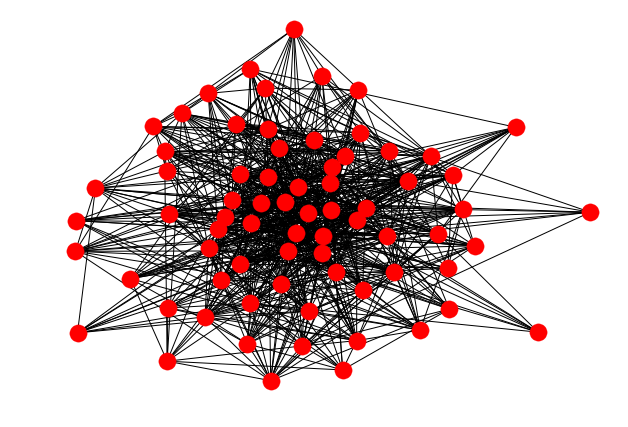

In [615]:
nodes = set(n for clq in cliques4 for n in clq)
h = GU.subgraph(nodes)
k = h.subgraph(nodes)
nx.draw(k)

In [616]:
H=list(nx.connected_component_subgraphs(GU))
print(len(H))

170


(array([169.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.,  44.,  87., 130., 173., 216., 259., 302., 345., 388., 431.]),
 <a list of 10 Patch objects>)

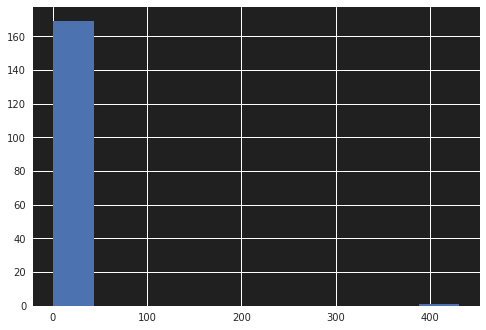

In [617]:
x=[len(c) for c in nx.connected_component_subgraphs(GU)]
plt.hist(x)

In [618]:
[len(c) for c in nx.connected_component_subgraphs(GU) if len(c) > 10]

[431]

In [0]:
nodes = cliques4[400]
h = GU.subgraph(nodes)

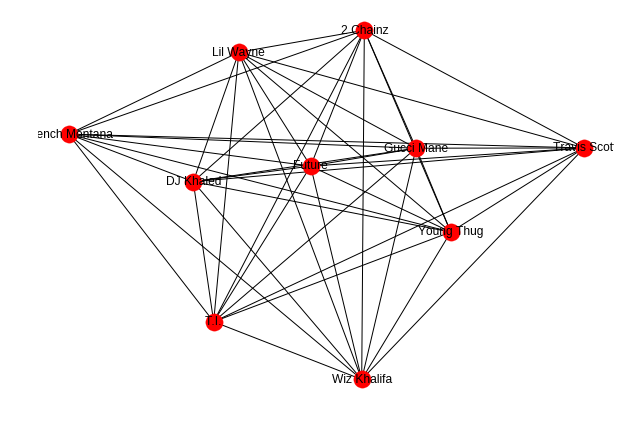

In [620]:
cliques_names = {k:v for k, v in names_dict.items() if k in h}
nx.draw(h,labels=cliques_names, with_labels = True)